# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


## Data Engineering

### Load Data

In [2]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Initial Data Exploration

First, we check the data attributes, quality and shape.

In [3]:
# Examine shape 
print(train_df.shape)

# Briefly examine feature attributes for the training data 
train_df.describe()

(15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


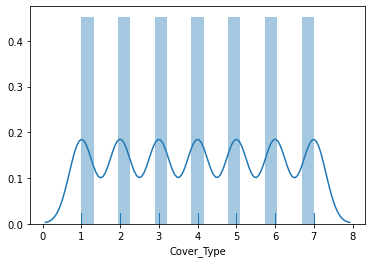

In [4]:
sns.distplot(train_df['Cover_Type'],rug=True)
plt.show()

Here we can see that the training data has a somewhat uniform distribution of covertype and this tells us that our data set is balanced. 

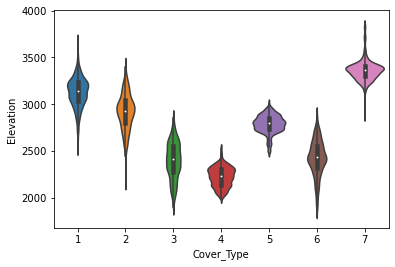

In [5]:
sns.violinplot(x=train_df['Cover_Type'],y=train_df['Elevation'])
plt.show()

Here, we can see there is a relationship between the cover type and elevation. 

In [6]:
# get NA values

print("There are {} NA values in the training data".format(train_df.isna().sum().sum()))
print("There are {} NA values in the test data".format(train_df.isna().sum().sum()))
    # `.isna()` returns a df with bools the first `.sum()` returns series, second is int 
print()
print("There are {} values in the training data".format(train_df.count()[0]))
print("There are {} values in the test data".format(test_df.count()[0]))

There are 0 NA values in the training data
There are 0 NA values in the test data

There are 15120 values in the training data
There are 565892 values in the test data


No null values in the dataset. Also noted the "aspect" variable has a value between 0 and 359. This is expressed in degrees, compared to "true north". Will conver this ino sine(EW) and cosine(NS) values. 

### Feature Engineering 1
Now we'll transform the "Aspect" into cosine and sine values to improve the representation of directions. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,asp_ew,asp_ns,jitter,asp_ew_jit,asp_ns_jit
0,0.670229,0.742154,1.543603,1.034567,1.145591
1,-0.521551,0.853220,1.517618,-0.791515,1.294862
2,0.696080,0.717964,1.517715,1.056452,1.089665
3,-0.873312,-0.487161,1.079391,-0.942645,-0.525838
4,0.850904,0.525322,1.195661,1.017392,0.628107


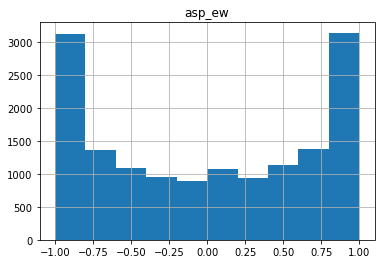

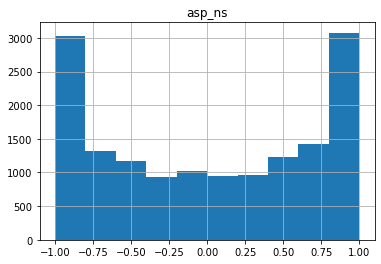

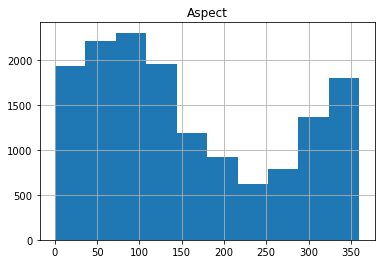

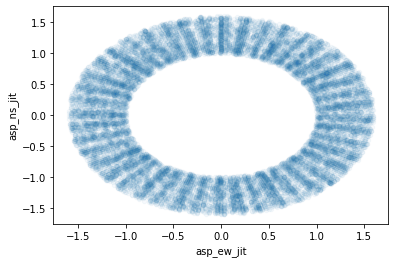

In [7]:
#split the aspect into a N/S and E/W unit vector
train_df["asp_ew"] = np.sin(train_df["Aspect"])
train_df["asp_ns"] = np.cos(train_df["Aspect"])


train_df["asp_ew"]**2 + train_df["asp_ns"]**2

train_df.hist(column = "asp_ew")
train_df.hist(column = "asp_ns")
train_df.hist(column = "Aspect")

df_circle = train_df[["asp_ew","asp_ns"]]
df_circle["jitter"] = np.random.rand(train_df.shape[0])*.6 +1
df_circle["asp_ew_jit"] = df_circle["asp_ew"] * df_circle["jitter"]
df_circle["asp_ns_jit"] = df_circle["asp_ns"] * df_circle["jitter"]

df_circle.plot.scatter("asp_ew_jit","asp_ns_jit",alpha=0.04)
df_circle.head()

In [8]:
#drop Aspect column
train_df.drop(columns=["Aspect"], inplace=True)

Now, we'll isolate and explore the distribution of soil types. 

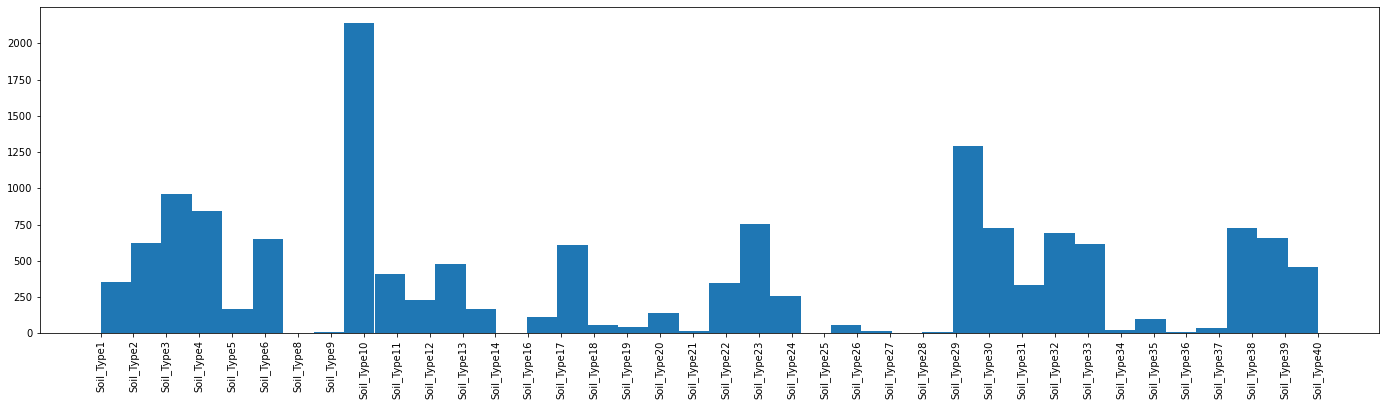

In [9]:
# Isolate soil type column names
soil_df = train_df[["Id",'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']]

# Now we convert the soil type columns back into one column with values as the "soil type"
soil_df_unpivoted = soil_df.melt(id_vars="Id",var_name="soil_type",value_name="yes")
mask1 = soil_df_unpivoted["yes"] ==1 #only keep rows of where the "soil type" is "yes"
soil_df_unpivoted = soil_df_unpivoted[mask1]


# Examine the fequencies of soil types
soil_df_unpivoted["soil_type"].value_counts().to_frame() 

# Histogram of soil types 
plt.figure(figsize=(24,6))
plt.hist(soil_df_unpivoted["soil_type"],bins=40)
plt.xticks(rotation=90)
plt.show()

As we can see in the histogram above, there is an uneven distribution of occurances of soil types.

In [10]:
# Explore correlations between features
train_corr=train_df.corr()
# Rank correlations with "cover type"
train_corr['Cover_Type'].abs().sort_values(ascending=False)

Cover_Type                            1.000000
Soil_Type38                           0.257810
Soil_Type39                           0.240384
Wilderness_Area1                      0.230117
Soil_Type29                           0.218564
Soil_Type40                           0.205851
Soil_Type22                           0.195993
Soil_Type23                           0.158762
Soil_Type32                           0.132312
Soil_Type12                           0.129985
Soil_Type10                           0.128972
Wilderness_Area3                      0.122146
Soil_Type35                           0.114327
Id                                    0.108363
Horizontal_Distance_To_Roadways       0.105662
Soil_Type24                           0.100797
Hillshade_Noon                        0.098905
Horizontal_Distance_To_Fire_Points    0.089389
Slope                                 0.087722
Soil_Type31                           0.079882
Soil_Type33                           0.078955
Wilderness_Ar

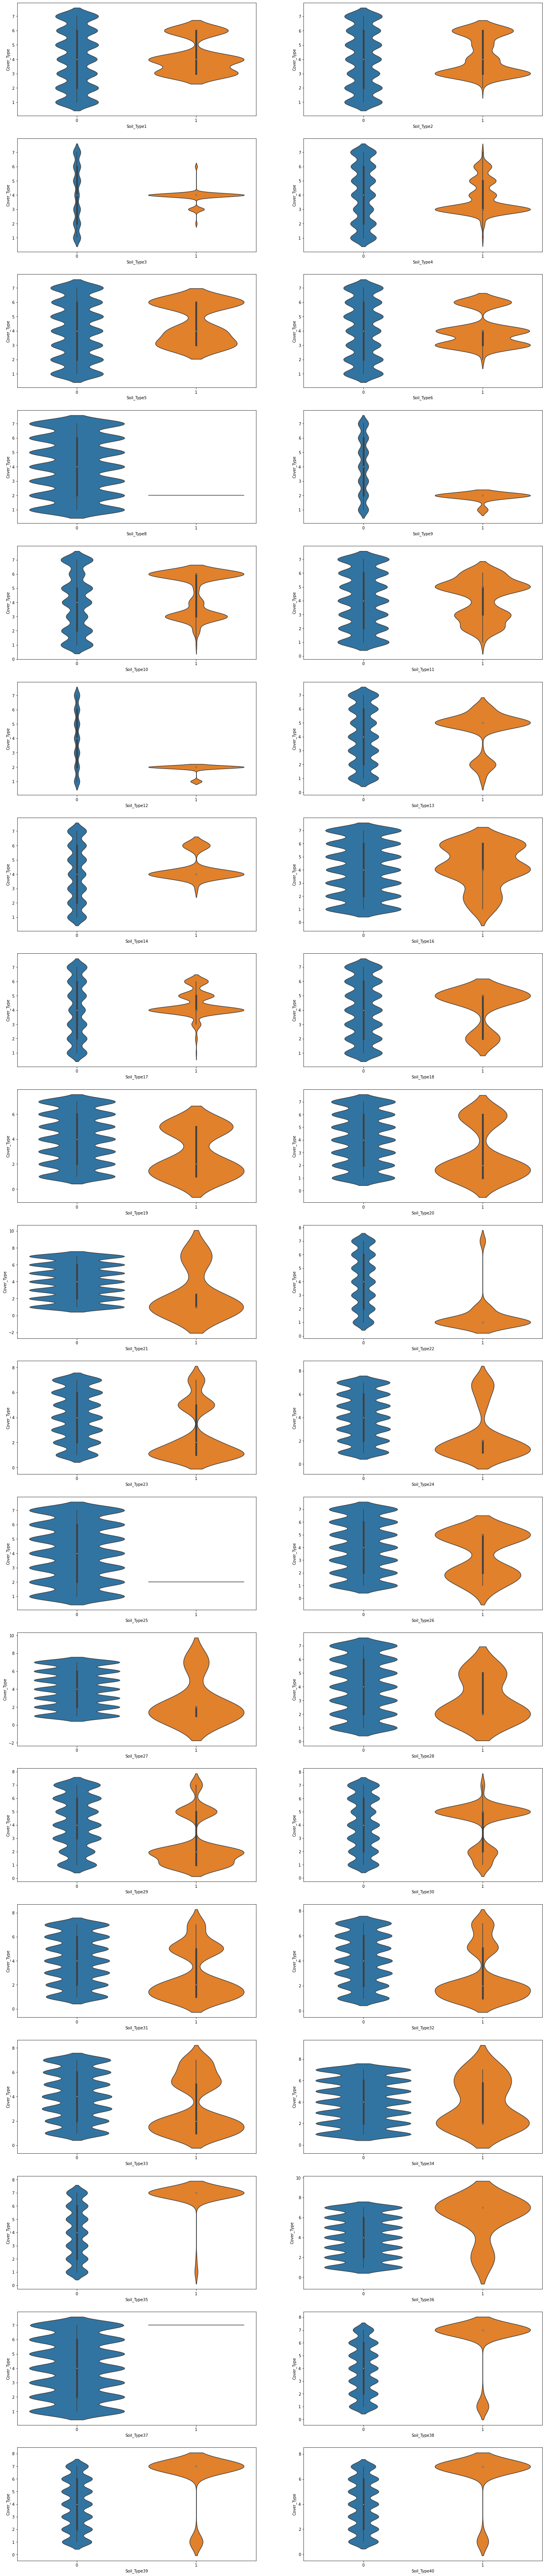

In [11]:
# Visualize the distribution of soil type and "cover type"
st_list = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16','Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

fig, axes = plt.subplots(19,2,figsize=(24,120))
for i in range(len(st_list)):
    sns.violinplot(y=train_df['Cover_Type'],x=train_df[st_list[i]], ax=axes[i//2,i%2])
plt.show()

Here we can examine the relationship between soil type and cover type for each soil type. # TODO: Discuss more

Now, we'll isolate and explore the distribution of wilderness types. 

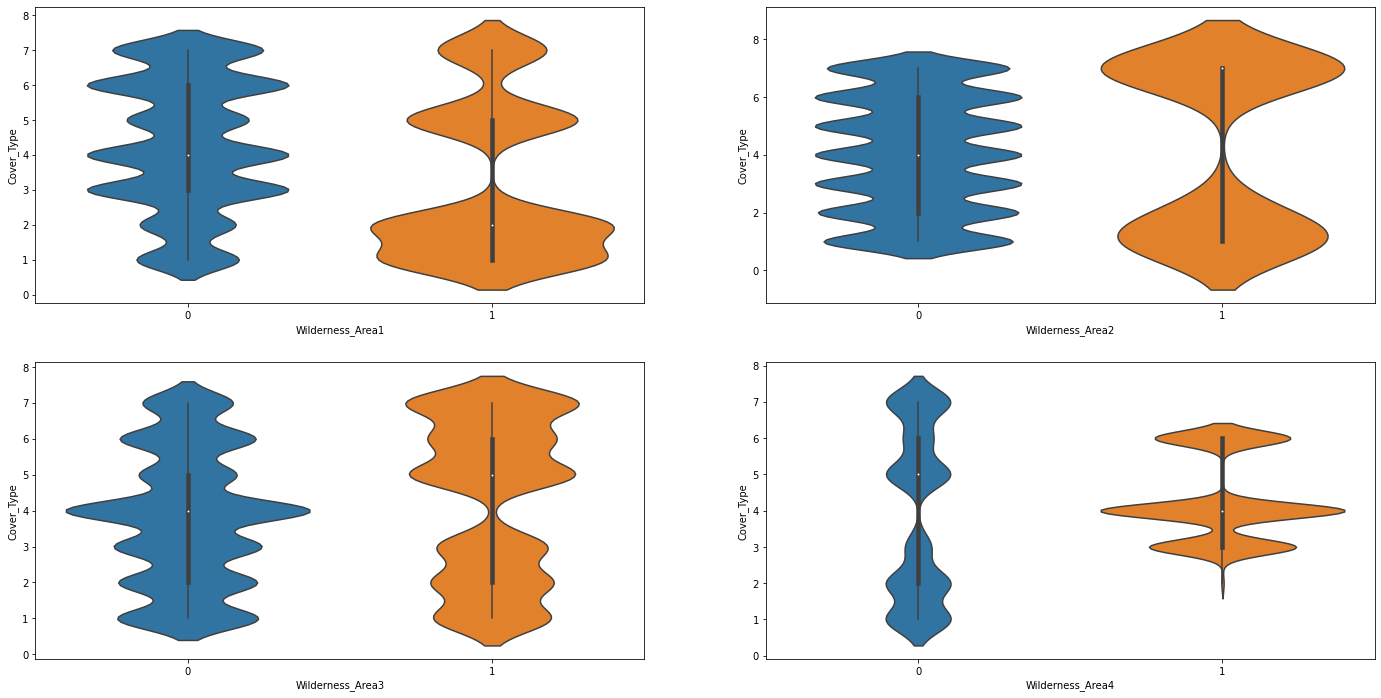

In [12]:
wilderness_list =['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4']

# Visualize the distribution of wilderness area and "cover type"
fig, axes = plt.subplots(2,2,figsize=(24,12))
for i in range(4):
    sns.violinplot(y=train_df['Cover_Type'],x=train_df[wilderness_list[i]], ax=axes[i//2,i%2])
plt.show()

### Feature Engineering 2

I'm going to hold off on dropping any soil types and just transform them to the new type

In [13]:
# # Remove soil type 7 and 15 due to no data
# train_df.drop(columns=["Soil_Type7", "Soil_Type15"], inplace=True)

# # Remove soil type 19, 37, 34, 21, 27,36,9, 28,8,25 due to no limited data - TODO: should we be dropping these? 
# train_df.drop(columns=["Soil_Type19", "Soil_Type37","Soil_Type34", "Soil_Type21","Soil_Type27", "Soil_Type36","Soil_Type9", "Soil_Type28","Soil_Type8", "Soil_Type25"], inplace=True)

# # Combine soil type 35,38,39, 40
# train_df["soil_type35383940"] = train_df["Soil_Type38"] +  train_df["Soil_Type39"] + train_df["Soil_Type40"] +  train_df["Soil_Type35"]
# train_df.drop(columns=["Soil_Type35","Soil_Type38", "Soil_Type39",'Soil_Type40'], inplace=True)

# # Check shape is as expected
# print(train_df.shape)


In [14]:
#drop Id column as it is not a meaningful feature.
train_df.drop(columns=["Id"],inplace=True)
test_df.drop(columns=["Id"],inplace=True)

## Soil Type

Right now we have 40 composite types of soil. We are going to re-categorize those into their component parts with a 1 for if a component is present. 0 if they are not present. 

#### Adjustments to the data 

Looking throught the data, we see several areas where the data can be cleaned. The USDA which is the cabinet department which oversees the forest service, publishes a guide on Soil Taxonomy. (https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/home/?cid=nrcs142p2_053577). This guide was very helpful in interpreting several areas where the data can be trimmed down. 

* Filler words
  * "Family / "families" denotes a larger soil group such as Leighcan or Cryaquolls, but these words themselves don't actually carry any information about the group. 
  * "complex" is another word that appears in the docuement but doesn't actually convey any information itself
  * "typic" just means that a soil fits into the most general subgroup of the family listed. In the context of the soil types listed, it is useless because only a few soil types list it, and those that don't list it don't list a more specific subgroup that they are a part of. So, they would also generally be assumed to be typic (see guide to soil taxonomy linked above.)
* Cryaquolis and aquolis types don't exist
  * Looking through the guide to soil taxonomy, there is no such type as cryaquolis and aquolis. The simplest interpretation is that these are typos. Cryaquolls and aquolls do exist (see link above). I will change the words accordingly.
  
#### Possible future work

* See if the "very/extremely" qualifiers on stony should be removed. Do they mean the same thing?
* See if changing "rubbly", "bouldery", "stoney" to all one indicator would be better. Do they all mean the same thing?

In [30]:
#### Analyze frequqncy that imporant types of soil show up ####

import re  #regexes to work with strings
from sklearn.feature_extraction.text import CountVectorizer #count up occurences of words
import numpy as np

# pull in the text of the soil types
with open("km_EDA/soil_raw.txt") as f:
    s_raw = f.read()

# lowercase everything to make it easier to work with
s = s_raw.lower()

# take out punctuation and numbers.
pattern = re.compile(r"[\d\.,-]")
s = pattern.sub(" ",s)

# take out filler words "family","families","complex"
pattern = re.compile(r"(family|families|complex|typic)")
s = pattern.sub(" ",s)

# replace cryaquolis/aquolis (doesn't exist) with cryaquolls/aquolls
pattern = re.compile(r"aquolis")
s = pattern.sub("aquolls",s)

# the "unspecified" row doesn't contain any data
pattern = re.compile(r"unspecified in the usfs soil and elu survey")
s = pattern.sub(" ",s)

#replace the space in words separated by a single space with an underscore
pattern = re.compile(r"(\w+) (\w+)")
s = pattern.sub(r"\1_\2",s)



### COUNT AND TRANSFORM THE DATA ###
cv = CountVectorizer()
# create the counts matrix based on word occurences in our processed soil types
counts = cv.fit_transform(s.split("\n"))
# we can use the counts as a transformation matrix to convert to our refined categories
xform = counts.toarray()

## Explanation of xform
    # It turns out that multiplying our original soil matrix by xform using matrix mutiplication
    # will just give us a matrix that has been converted to the new feature space. 

# Grab out the new features (that are replacing s_01 thru s_40)
new_cats = cv.get_feature_names()
print("-- New Feature Names --")
print(new_cats,"\n")

# get original soil names
og_soil_col_names = [("Soil_Type{:d}".format(ii+1)) for ii in range(40)]

# get columns containing soil information from our dataframe.
soil_cols = np.array(train_df[og_soil_col_names])

# transform the soil features. Put them into a dataframe.
trans_soil = np.matmul(soil_cols,xform)
trans_soil_df = pd.DataFrame(data = trans_soil, columns = new_cats)
display(trans_soil_df)

# combine the new soil features with the existing freatures in a single df
df_new = train_df.drop(columns=og_soil_col_names)
df_new = pd.concat([df_new, trans_soil_df],axis=1)
df_new = df_new[[col for col in df_new if col not in ["Cover_Type"]]+["Cover_Type"]] #want cover type as last column
display(df_new)

# We'll just reassign the train_df here to be equal to df_new
train_df = df_new

-- New Feature Names --
['aquolls', 'borohemists', 'bross', 'bullwark', 'catamount', 'cathedral', 'como', 'cryaquepts', 'cryaquolls', 'cryoborolis', 'cryorthents', 'cryumbrepts', 'extremely_bouldery', 'extremely_stony', 'gateview', 'gothic', 'granile', 'haploborolis', 'legault', 'leighcan', 'limber', 'moran', 'pachic_argiborolis', 'ratake', 'rock_land', 'rock_outcrop', 'rogert', 'rubbly', 'stony', 'supervisor', 'till_substratum', 'troutville', 'vanet', 'very_stony', 'warm', 'wetmore'] 



,aquolls,borohemists,bross,bullwark,catamount,cathedral,como,cryaquepts,cryaquolls,cryoborolis,...,rogert,rubbly,stony,supervisor,till_substratum,troutville,vanet,very_stony,warm,wetmore
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15116,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15117,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15118,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,rubbly,stony,supervisor,till_substratum,troutville,vanet,very_stony,warm,wetmore,Cover_Type
0,2596,3,258,0,510,221,232,148,6279,1,...,0,0,0,0,0,0,0,0,0,5
1,2590,2,212,-6,390,220,235,151,6225,1,...,0,0,0,0,0,0,0,0,0,5
2,2804,9,268,65,3180,234,238,135,6121,1,...,0,1,0,0,0,0,0,0,0,2
3,2785,18,242,118,3090,238,238,122,6211,1,...,0,0,0,0,0,0,0,0,0,2
4,2595,2,153,-1,391,220,234,150,6172,1,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2607,23,258,7,660,170,251,214,1282,0,...,1,0,0,0,0,0,0,0,0,3
15116,2603,19,633,195,618,249,221,91,1325,0,...,1,0,0,0,0,0,0,0,0,3
15117,2492,25,365,117,335,250,220,83,1187,0,...,1,0,0,0,0,0,0,0,0,3
15118,2487,28,218,101,242,229,237,119,932,0,...,1,0,0,0,0,0,0,0,0,3


### Additional Data Mungling

Then, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [31]:
# Split training data (labeled) into 80% training and 20% dev) and randomly sample 
training_data = train_df.sample(frac=0.8)
dev_data_df = train_df.drop(training_data.index)

# Examine shape of both data sets
print(training_data.shape)
print(dev_data_df.shape)

# Briefly examine feature attributes for the training data 
display(training_data.describe())
display(dev_data_df.describe())

(12096, 52)
(3024, 52)


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,rubbly,stony,supervisor,till_substratum,troutville,vanet,very_stony,warm,wetmore,Cover_Type
count,12096.00000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,...,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,2748.89294,16.498016,226.298694,50.666749,1713.295387,212.657490,219.085813,135.252397,1508.751736,0.237930,...,0.329034,0.058449,0.000083,0.074157,0.000744,0.096478,0.050347,0.001075,0.043155,3.987434
std,417.38242,8.459147,210.471922,61.176043,1318.020151,30.669226,22.727316,45.980340,1099.393886,0.425834,...,0.469882,0.234600,0.009092,0.262037,0.027268,0.295258,0.218669,0.032767,0.203214,1.997354
min,1879.00000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2374.75000,10.000000,60.000000,5.000000,765.000000,196.000000,207.000000,107.000000,726.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2751.00000,15.000000,180.000000,32.000000,1320.000000,220.000000,223.000000,138.000000,1260.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3101.00000,22.000000,324.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1982.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.00000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,rubbly,stony,supervisor,till_substratum,troutville,vanet,very_stony,warm,wetmore,Cover_Type
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,...,3024.000000,3024.000000,3024.0,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,2751.041005,16.515873,230.783730,52.715608,1716.934524,212.891534,218.484788,134.450397,1520.729497,0.237765,...,0.335317,0.056217,0.0,0.073082,0.000331,0.089616,0.045635,0.000992,0.042328,4.050265
std,418.923936,8.434395,208.477255,61.475036,1353.101803,30.129956,23.095691,45.554904,1102.234259,0.425785,...,0.472179,0.230378,0.0,0.260314,0.018185,0.285679,0.208727,0.031487,0.201370,2.010423
min,1863.000000,0.000000,0.000000,-114.000000,0.000000,80.000000,113.000000,0.000000,30.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2379.000000,10.000000,67.000000,5.000000,750.000000,196.000000,206.000000,106.000000,743.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2753.000000,16.000000,182.000000,34.000000,1296.000000,220.000000,222.000000,138.000000,1245.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3119.000000,22.000000,335.000000,82.000000,2278.250000,235.000000,235.000000,166.000000,2012.000000,0.000000,...,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,46.000000,1213.000000,547.000000,6836.000000,254.000000,254.000000,248.000000,6853.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


Additionally, we will scale the training data to have a mean of 0 and a variance of 1. Then we will retrieve the original training mean and variance for each feature and use that to standardize the development data.

In [32]:
# Split into data and labels
train_data = training_data.drop(columns=["Cover_Type"])
train_labels = training_data["Cover_Type"]
dev_data = dev_data_df.drop(columns=["Cover_Type"])
dev_labels = dev_data_df["Cover_Type"]
test_data = test_df

# Double check the shape
print(train_data.shape)
print(dev_data.shape)

(12096, 51)
(3024, 51)


In [33]:
train_data.columns

Index(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'asp_ew',
       'asp_ns', 'aquolls', 'borohemists', 'bross', 'bullwark', 'catamount',
       'cathedral', 'como', 'cryaquepts', 'cryaquolls', 'cryoborolis',
       'cryorthents', 'cryumbrepts', 'extremely_bouldery', 'extremely_stony',
       'gateview', 'gothic', 'granile', 'haploborolis', 'legault', 'leighcan',
       'limber', 'moran', 'pachic_argiborolis', 'ratake', 'rock_land',
       'rock_outcrop', 'rogert', 'rubbly', 'stony', 'supervisor',
       'till_substratum', 'troutville', 'vanet', 'very_stony', 'warm',
       'wetmore'],
      dtype='object')

In [34]:
# Collect numeric feature column names - so we can easily access these columns when modifying them 
num_cols = ['Elevation', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

# Normalize features using the standard scaler [training data]
scaler = StandardScaler()
norm = scaler.fit(train_data[num_cols])
train_data[num_cols] = norm.transform(train_data[num_cols])
print(train_data.shape)
# Normalize features using the standard scaler [dev data]
dev_data[num_cols] = norm.transform(dev_data[num_cols])
print(dev_data.shape)



(12096, 51)
(3024, 51)


In [35]:
# Double check shape
print(train_data.shape, dev_data.shape)

(12096, 51) (3024, 51)


In [36]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}".format(dev_data.shape, dev_data.shape))
print("Test data shape: ", test_data.shape)

Training data shape: (12096, 51) Training labels shape: (12096,)
Dev data shape: (3024, 51) Dev labels shape: (3024, 51)
Test data shape:  (565892, 54)


In [37]:
# Examine Training Data 
dev_data.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,rogert,rubbly,stony,supervisor,till_substratum,troutville,vanet,very_stony,warm,wetmore
2,0.132036,-0.886416,0.198141,0.234305,1.112855,0.695922,0.832257,-0.005489,4.195438,1,...,0,0,1,0,0,0,0,0,0,0
4,-0.368725,-1.713957,-0.348273,-0.844593,-1.003285,0.239420,0.656250,0.320750,4.241829,1,...,0,0,0,0,0,0,0,0,0,0
7,-0.344765,-1.477517,0.036592,-0.713818,-0.865194,0.304634,0.480243,0.190254,4.292768,1,...,0,0,0,0,0,0,0,0,0,0
11,0.328506,-0.649976,0.687537,-0.403226,2.685734,0.695922,0.920261,0.016260,2.312505,1,...,0,0,0,0,0,0,0,0,0,0
13,-0.335181,-1.122857,-0.362527,-0.076287,-0.714962,0.011168,1.228273,0.755737,4.277305,1,...,1,0,0,0,0,0,0,1,0,0


## Models
#### Random Forest

Random Forest Performance for 1 trees: 0.6173941798941799
Random Forest Performance for 3 trees: 0.7083333333333334
Random Forest Performance for 5 trees: 0.7083333333333334
Random Forest Performance for 10 trees: 0.7430555555555556
Random Forest Performance for 100 trees: 0.7509920634920635


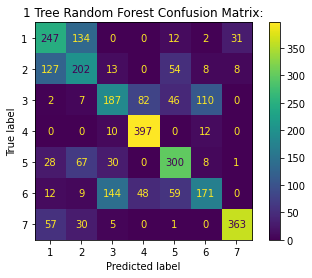

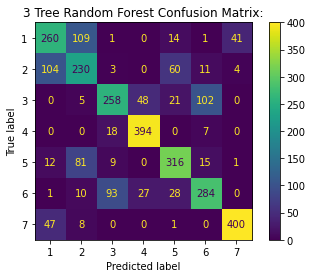

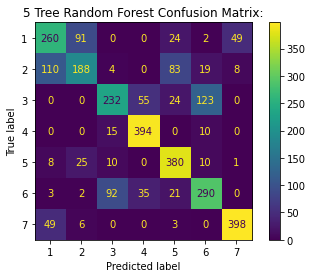

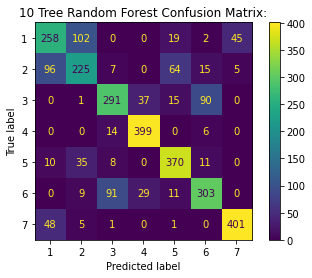

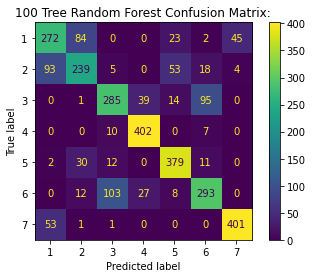

In [38]:
# Try a random forest - before any data cleaning 
def RandomForest(num_trees):
    model = RandomForestClassifier(num_trees,max_depth=8)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("Random Forest Performance for {0} trees: {1}".format(num_trees,score))
    # Plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("{} Tree Random Forest Confusion Matrix:".format(num_trees))
    plt.plot()
    
num_trees_list = [1,3,5,10,100]
for num_trees in num_trees_list:
    RandomForest(num_trees)

#### Naive Bayes (Bernoulli)

BernoulliNB for alph = 0.01: accuracy = 0.6031746031746031





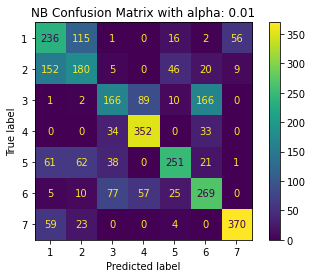

In [39]:
# Try Naive Bayes - before any data cleaning 
def NB(alf):
    model = BernoulliNB(alpha = alf)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("BernoulliNB for alph = {0}: accuracy = {1}".format(alf,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("NB Confusion Matrix with alpha: {}".format(alf))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
alphas_list = [0.01]
for alpha in alphas_list:
    NB(alpha)

#### K-Nearest Neighbors

KNN 1 neighbors : accuracy = 0.7496693121693122
KNN 2 neighbors : accuracy = 0.7235449735449735
KNN 4 neighbors : accuracy = 0.7321428571428571
KNN 7 neighbors : accuracy = 0.7314814814814815
KNN 10 neighbors : accuracy = 0.7291666666666666


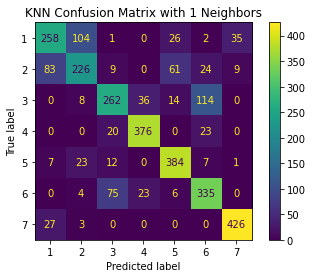

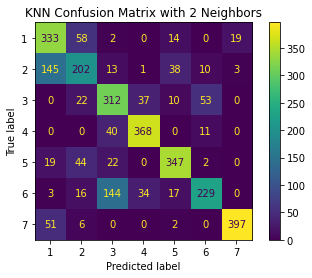

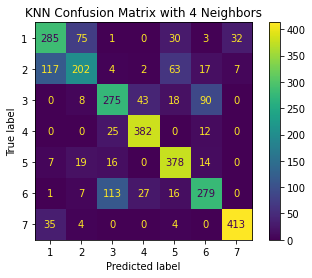

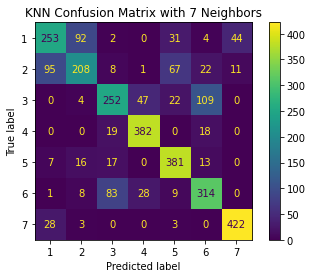

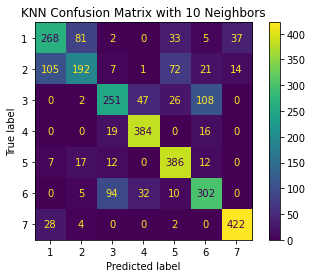

In [40]:
# Try K Nearest Neighbors - before any data cleaning 
def KNN(kn):
    model = KNeighborsClassifier(n_neighbors = kn)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("KNN {0} neighbors : accuracy = {1}".format(kn,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("KNN Confusion Matrix with {} Neighbors".format(kn))
    plt.plot()
    
# The alpha isn't actually making a difference 
neigh_list = [1,2,4, 7, 10]
for neigh in neigh_list:
    KNN(neigh)

#### Multi-layer Perceptron

In [41]:
# Try Multi-Layer Perceptron - before any data cleaning 
def MLP():
#    model = MLPClassifier(solver='adam', alpha=1e-6, hidden_layer_sizes=(100, ), random_state=0) .8257
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0)  .82969
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(200, ), random_state=0) .837
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0, activation='tanh') .83068

    # Default activation is 'relu', random state lets us get the same result every time (so we can tune other parameters)
    # max_iter is 200 by default, but more helps. alpha is the regularization parameter. solver is 'adam' by default
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(100,), random_state=0, max_iter=300) 
    model.fit(train_data, train_labels) 
    score = model.score(dev_data, dev_labels)
    print("MLP accuracy = ",score)

    
MLP()

MLP accuracy =  0.8161375661375662


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * the url for it
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [42]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear-cut-solution.ipynb --to="python" --output="backups/clear-cut-solution"
!jupyter nbconvert clear-cut-solution.ipynb --to markdown --output="backups/clear-cut-solution"

# Also archiving this bad boy
!jupyter nbconvert clear-cut-solution.ipynb --to html --output="backups/clear-cut-solution"

[NbConvertApp] Converting notebook clear-cut-solution.ipynb to python
[NbConvertApp] Writing 18073 bytes to backups/clear-cut-solution.py
[NbConvertApp] Converting notebook clear-cut-solution.ipynb to markdown
[NbConvertApp] Support files will be in backups/clear-cut-solution_files/
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_files/backups
[NbConvertApp] Making directory backups/clear-cut-solution_